In [93]:
# %load_ext lab_black
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint
import black

import sqlalchemy
from sqlalchemy import create_engine, inspect, func, MetaData, desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
Base = automap_base()

In [50]:
Base.prepare(engine, reflect=True)

In [51]:
session = Session(engine)

In [52]:
measurement = Base.classes.measurement
first_row = session.query(measurement).first()
print(first_row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11F92BF0>, 'prcp': 0.08, 'tobs': 65.0, 'id': 1, 'station': 'USC00519397', 'date': '2010-01-01'}


In [53]:
for row in (
    session.query(measurement.station, measurement.date, measurement.prcp)
    .limit(10)
    .all()
):
    print(row)

('USC00519397', '2010-01-01', 0.08)
('USC00519397', '2010-01-02', 0.0)
('USC00519397', '2010-01-03', 0.0)
('USC00519397', '2010-01-04', 0.0)
('USC00519397', '2010-01-06', None)
('USC00519397', '2010-01-07', 0.06)
('USC00519397', '2010-01-08', 0.0)
('USC00519397', '2010-01-09', 0.0)
('USC00519397', '2010-01-10', 0.0)
('USC00519397', '2010-01-11', 0.01)


In [54]:
station = Base.classes.station
first_row2 = session.query(station).first()
print(first_row2.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x11F77430>, 'name': 'WAIKIKI 717.2, HI US', 'elevation': 3.0, 'station': 'USC00519397', 'longitude': -157.8168, 'id': 1, 'latitude': 21.2716}


In [55]:
session.query(station.station, station.name).all()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [56]:
honolulu = (
    session.query(station.station).filter(station.name.like("%HONOLULU%")).all()[0][0]
)

In [57]:
#Dates just for Honolulu
for row in (session.query(measurement.date, measurement.prcp).filter(measurement.station == honolulu)).order_by(measurement.date.desc()).limit(10):
    print(row)

('2015-10-30', 0.0)
('2015-10-29', 0.0)
('2015-10-28', 0.0)
('2015-10-26', 0.1)
('2015-10-25', 0.0)
('2015-10-22', 0.15)
('2015-10-21', 0.0)
('2015-10-20', 0.3)
('2015-10-19', 0.0)
('2015-10-16', 0.0)


In [58]:
#All dates
for row in (session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).limit(10)):
            print(row)

('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-21', 0.0)
('2017-08-21', 0.02)
('2017-08-21', None)


Start date 8/23/2017 | End date 9/1/2017

In [59]:
for row in (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date < dt.datetime(2017, 8, 23))
    .filter(measurement.date > dt.datetime(2016, 8, 23))
    .limit(10)
):
    print(row)

('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)
('2016-08-28', 0.01)
('2016-08-29', 0.0)
('2016-08-30', 0.0)
('2016-08-31', 0.13)
('2016-09-01', 0.0)
('2016-09-02', 0.0)


In [82]:
prcp_query = []
for row in (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date <= dt.date(2017, 8, 23))
    .filter(measurement.date >= dt.date(2016, 8, 23))
):
    prcp_query.append(row)

In [83]:
df = pd.DataFrame(prcp_query, columns=["date", "prcp"])

In [84]:
df = df.sort_values(by=["date"])

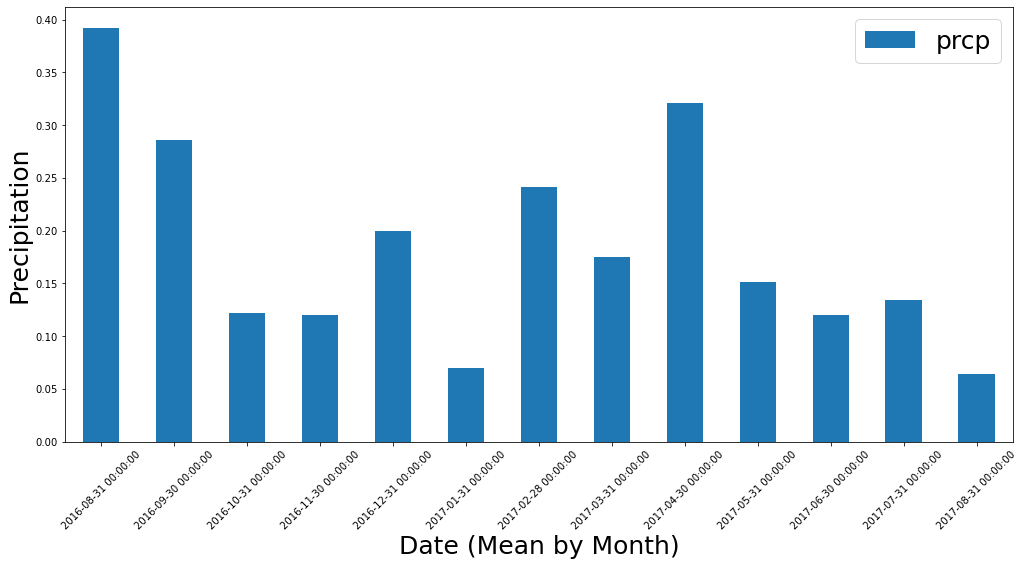

In [85]:
df.assign(date=pd.to_datetime(df["date"])).groupby(pd.Grouper(key="date", freq="1M")).mean().plot.bar(figsize = (17,8))
plt.xlabel('Date (Mean by Month)', size = 25)
plt.ylabel('Precipitation', size = 25)
plt.legend(fontsize = 25)
plt.xticks(rotation = 45)
plt.show()


In [86]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [102]:
session.query(func.count(session.query(measurement.station).group_by(measurement.station))).all()

[(9)]

In [95]:
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [106]:
session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [117]:
#Highest number of temperature observations
most_temp = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.tobs).order_by(desc(func.count(measurement.tobs))).limit(1).all()

In [118]:
most_temp_data = []
for row in (
    session.query(measurement.date, measurement.tobs)
    .filter(measurement.station == most_temp[0][0])
    .filter(measurement.date <= dt.date(2017, 8, 23))
    .filter(measurement.date >= dt.date(2016, 8, 23))
):
    most_temp_data.append(row)

In [122]:
temp_df = pd.DataFrame(most_temp_data, columns = ['Date', 'TOBS'])

In [123]:
temp_df.head()

,Date,TOBS
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


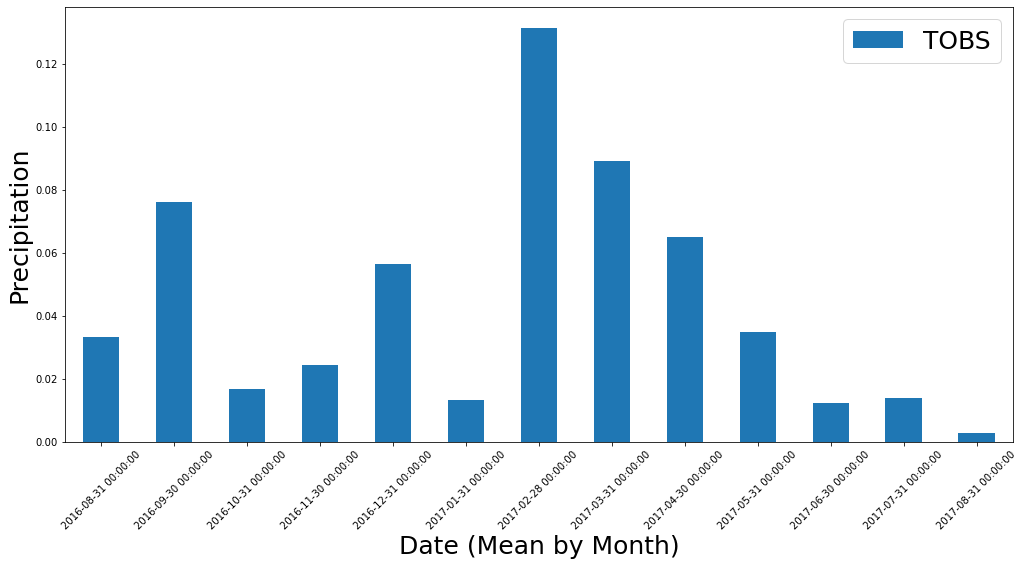

In [126]:
temp_df.assign(Date=pd.to_datetime(temp_df["Date"])).groupby(pd.Grouper(key="Date", freq="1M")).mean().plot.bar(figsize = (17,8))
plt.xlabel('Date (Mean by Month)', size = 25)
plt.ylabel('Precipitation', size = 25)
plt.legend(fontsize = 25)
plt.xticks(rotation = 45)
plt.show()